# Подключаем библиотеки

In [1]:
from math import pi
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error
import re
from datetime import datetime
from datetime import time
from torch.utils.data import Dataset, DataLoader
from torch import Tensor
from torch.nn import Module, Linear, Sigmoid, LeakyReLU, Tanh, Softmax, Sequential, MSELoss
from torch.optim import Adam, SGD

In [2]:
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

# Считываем и выводим данные

In [3]:
df_business = pd.read_excel('Train.xlsx', sheet_name='business')
df_business['class'] = np.ones(df_business.shape[0])
df_economy = pd.read_excel('Train.xlsx', sheet_name='economy')
df_economy['class'] = np.zeros(df_economy.shape[0])

In [4]:
df = pd.concat([df_business, df_economy], axis=0)
df.shape

(240208, 12)

Удаляем дубликаты

In [5]:
df.drop_duplicates(inplace=True)
df.shape

(240208, 12)

Перемешиваем таблицу

In [6]:
df = df.sample(frac=1, random_state=42).reset_index(drop=True)
df.head()

,date,airline,ch_code,num_code,dep_time,from,time_taken,stop,arr_time,to,price,class
0,09-03-2022,Air India,AI,770,20:30,Kolkata,02h 30m,non-stop,23:00,Delhi,"28,510",1.0
1,02-03-2022,Vistara,UK,963,08:50,Delhi,08h 55m,1-stop\n\t\t\t\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t\t...,17:45,Bangalore,"4,896",0.0
2,23-02-2022,Vistara,UK,876,21:35,Hyderabad,22h 20m,1-stop\n\t\t\t\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t\t...,19:55,Chennai,"8,641",0.0
3,14-03-2022,Vistara,UK,927,09:30,Delhi,11h 25m,1-stop\n\t\t\t\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t\t...,20:55,Bangalore,"4,496",0.0
4,27-03-2022,Indigo,6E,7211,10:55,Hyderabad,03h 55m,1-stop\n\t\t\t\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t\t...,14:50,Bangalore,"3,374",0.0


In [7]:
df.shape

(240208, 12)

# Обработка данных

Приведём столбец цены к типу данных float

In [8]:
df['price'] = df['price'].apply(lambda x: float(x.replace(',', '')))

Очистка от выбросов

Приводим строки к соответствующему формату

In [9]:
df = df.astype({'airline': 'string', 'ch_code': 'string', \
                'from': 'string', 'to': 'string'})

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240208 entries, 0 to 240207
Data columns (total 12 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   date        240208 non-null  object 
 1   airline     240208 non-null  string 
 2   ch_code     240208 non-null  string 
 3   num_code    240208 non-null  int64  
 4   dep_time    240208 non-null  object 
 5   from        240208 non-null  string 
 6   time_taken  240208 non-null  object 
 7   stop        240208 non-null  object 
 8   arr_time    240208 non-null  object 
 9   to          240208 non-null  string 
 10  price       240208 non-null  float64
 11  class       240208 non-null  float64
dtypes: float64(2), int64(1), object(5), string(4)
memory usage: 22.0+ MB


Функция приведения столбца с описанием пересадок в структурированных вид

0 - без пересадок

1 - 1 пересадка

2 - 2 и более пересадок

In [11]:
def text_to_stop_categories(text:str):
    if text[0] == 'n':
        return 0
    elif text[0] == '1':
        return 1
    return 2

Функция определения, является ли время ночным или дневным (0 - ночь, 1 - день)

In [12]:
def time_to_daytime(time_str):
    time_obj = datetime.strptime(time_str, '%H:%M')
    if time_obj.hour >= 8 and time_obj.hour < 20:
        return 1
    return 0

Функция подсчёта количества минут

In [13]:
def time_to_minutes(time_str:str):
    time_obj = re.findall(r'\d{1,}', time_str)
    return int(time_obj[0]) * 60 + int(time_obj[1])

Применяем к нужным столбцам соответствующие изменения

Преобразуем авиалинию и ch_code в бинарный признак

In [14]:
df['stop_categories'] = df['stop'].apply(text_to_stop_categories)
df['dep_time_category'] = df['dep_time'].apply(time_to_daytime)
df['arr_time_category'] = df['arr_time'].apply(time_to_daytime)
df['time_taken_minutes'] = df['time_taken'].apply(time_to_minutes)
df.head()

,date,airline,ch_code,num_code,dep_time,from,time_taken,stop,arr_time,to,price,class,stop_categories,dep_time_category,arr_time_category,time_taken_minutes
0,09-03-2022,Air India,AI,770,20:30,Kolkata,02h 30m,non-stop,23:00,Delhi,28510.0,1.0,0,0,0,150
1,02-03-2022,Vistara,UK,963,08:50,Delhi,08h 55m,1-stop\n\t\t\t\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t\t...,17:45,Bangalore,4896.0,0.0,1,1,1,535
2,23-02-2022,Vistara,UK,876,21:35,Hyderabad,22h 20m,1-stop\n\t\t\t\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t\t...,19:55,Chennai,8641.0,0.0,1,0,1,1340
3,14-03-2022,Vistara,UK,927,09:30,Delhi,11h 25m,1-stop\n\t\t\t\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t\t...,20:55,Bangalore,4496.0,0.0,1,1,0,685
4,27-03-2022,Indigo,6E,7211,10:55,Hyderabad,03h 55m,1-stop\n\t\t\t\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t\t...,14:50,Bangalore,3374.0,0.0,1,1,1,235


Теперь закодируем признак, обозначающий количество пересадок, с помощью вектора из нулей и единиц

In [15]:
stop_category_encoder = OneHotEncoder()
stop_category_encoder.fit(df[['stop_categories']])
df[['stop0', 'stop1', 'stop2']] = stop_category_encoder.transform(df[['stop_categories']]).toarray()

Аналогичным образом закодируем признак авиакомпании

In [16]:
airline_encoder = OneHotEncoder()
airline_encoder.fit(df[['airline']])
df[[f'airline_{i.replace(' ', '_').lower()}' for i in airline_encoder.categories_[0]]] = \
airline_encoder.transform(df[['airline']]).toarray()

Будем учитывать расстояния между городами

In [17]:
city_indexes = {'Bangalore': 0, 'Chennai': 1, 'Delhi': 2, \
                'Hyderabad': 3, 'Kolkata': 4, 'Mumbai': 5}
city_dists = [
    [     0,          290,          1720,           1680,          1550,            830  ],
    [   290,            0,          1760,           1840,          1360,           1050  ],
    [  1720,         1760,             0,           1250,          1300,           1160  ],
    [  1680,         1840,          1250,              0,          2060,            850  ],
    [  1550,         1360,          1300,           2060,             0,           1650  ],
    [  830,          1050,          1160,            850,          1650,              0  ]
]

In [18]:
df['dist'] = df.apply(lambda x: city_dists[city_indexes[x['from']]]\
                      [city_indexes[x['to']]], axis=1)

Закодируем время вылета и прилёта двумя числами

In [19]:
arr_time_angle = np.array(df['arr_time'].apply(time_to_minutes)).astype('float64')
arr_time_angle /= 60 * 24
arr_time_angle *= 2 * pi
dep_time_angle = np.array(df['dep_time'].apply(time_to_minutes)).astype('float64')
dep_time_angle /= 60 * 24
dep_time_angle *= 2 * pi
df['arr_time_x'] = np.cos(arr_time_angle)
df['arr_time_y'] = np.sin(arr_time_angle)
df['dep_time_x'] = np.cos(dep_time_angle)
df['dep_time_y'] = np.sin(dep_time_angle)

Посмотрим на результат

In [20]:
df.head()

,date,airline,ch_code,num_code,dep_time,from,time_taken,stop,arr_time,to,price,class,stop_categories,dep_time_category,arr_time_category,time_taken_minutes,stop0,stop1,stop2,airline_air_india,airline_airasia,airline_go_first,airline_indigo,airline_spicejet,airline_starair,airline_trujet,airline_vistara,dist,arr_time_x,arr_time_y,dep_time_x,dep_time_y
0,09-03-2022,Air India,AI,770,20:30,Kolkata,02h 30m,non-stop,23:00,Delhi,28510.0,1.0,0,0,0,150,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1300,0.965926,-0.258819,0.608761,-0.793353
1,02-03-2022,Vistara,UK,963,08:50,Delhi,08h 55m,1-stop\n\t\t\t\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t\t...,17:45,Bangalore,4896.0,0.0,1,1,1,535,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1720,-0.065403,-0.997859,-0.675590,0.737277
2,23-02-2022,Vistara,UK,876,21:35,Hyderabad,22h 20m,1-stop\n\t\t\t\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t\t...,19:55,Chennai,8641.0,0.0,1,0,1,1340,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1840,0.480989,-0.876727,0.806445,-0.591310
3,14-03-2022,Vistara,UK,927,09:30,Delhi,11h 25m,1-stop\n\t\t\t\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t\t...,20:55,Bangalore,4496.0,0.0,1,1,0,685,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1720,0.691513,-0.722364,-0.793353,0.608761
4,27-03-2022,Indigo,6E,7211,10:55,Hyderabad,03h 55m,1-stop\n\t\t\t\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t\t...,14:50,Bangalore,3374.0,0.0,1,1,1,235,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1680,-0.737277,-0.675590,-0.960050,0.279829


# Подготовка данных

Разделим таблицу на признаки и целевую переменную

In [21]:
X = df[df.columns[11:]]
X.drop(columns='stop_categories', inplace=True)
y = df[['price']]

Разделим данные на тренировочные, валидационные и тестовые

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, \
                                                    random_state=42, shuffle=True)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, \
                                                  random_state=42, shuffle=True)

# Проанализируем данные

Посмотрим на корреляцию между признаками

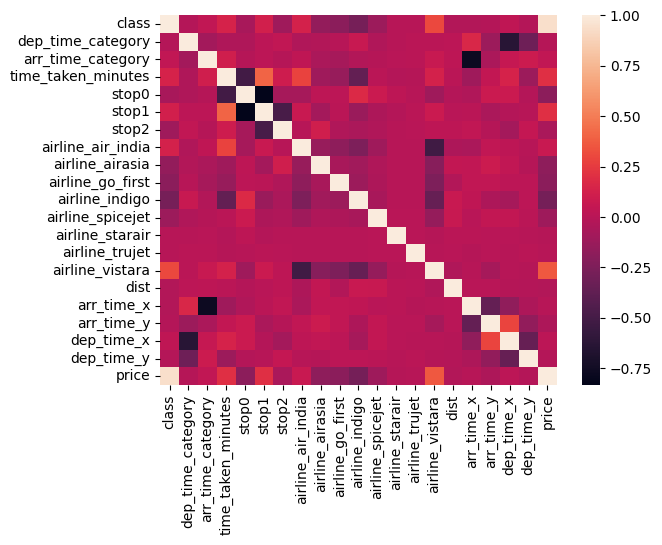

In [23]:
sns.heatmap(pd.concat([X_train, y_train], axis=1).corr());

In [24]:
pd.DataFrame(pd.concat([X_train, y_train], axis=1).corr())

,class,dep_time_category,arr_time_category,time_taken_minutes,stop0,stop1,stop2,airline_air_india,airline_airasia,airline_go_first,airline_indigo,airline_spicejet,airline_starair,airline_trujet,airline_vistara,dist,arr_time_x,arr_time_y,dep_time_x,dep_time_y,price
class,1.000000,-0.020323,0.040046,0.139651,-0.068166,0.118533,-0.105900,0.127836,-0.159290,-0.195114,-0.275982,-0.117353,-0.009505,-0.007317,0.300717,-0.027567,-0.024478,-0.019072,0.033119,-0.022375,0.938257
dep_time_category,-0.020323,1.000000,-0.092548,-0.040761,-0.039830,0.015200,0.035585,-0.032903,-0.027810,-0.006440,0.064879,-0.032310,-0.008487,0.008475,0.010663,0.012530,0.156380,-0.121007,-0.637225,-0.314229,-0.010840
arr_time_category,0.040046,-0.092548,1.000000,0.109866,-0.012389,0.018651,-0.014032,0.030133,-0.059639,-0.074467,-0.028498,-0.012609,0.000944,0.008962,0.064860,0.025487,-0.770871,-0.056496,0.055879,0.085197,0.039503
time_taken_minutes,0.139651,-0.040761,0.109866,1.000000,-0.514013,0.399151,0.093260,0.279165,-0.107380,-0.140481,-0.367105,0.011077,-0.019354,-0.013344,0.132701,0.005509,-0.109868,0.047400,0.139339,-0.121594,0.204962
stop0,-0.068166,-0.039830,-0.012389,-0.514013,1.000000,-0.833230,-0.079229,-0.077419,0.024261,0.016264,0.176291,0.080886,0.023866,-0.004023,-0.104203,-0.019533,-0.032905,0.076891,0.077758,-0.021519,-0.186555
stop1,0.118533,0.015200,0.018651,0.399151,-0.833230,1.000000,-0.485172,0.070684,-0.083418,0.006527,-0.125207,-0.050111,-0.019246,0.004828,0.077702,0.003070,0.008027,-0.058818,-0.020359,-0.007526,0.199171
stop2,-0.105900,0.035585,-0.014032,0.093260,-0.079229,-0.485172,1.000000,-0.005001,0.112025,-0.037489,-0.053061,-0.037572,-0.003043,-0.002343,0.024704,0.025355,0.037566,-0.015558,-0.086264,0.047599,-0.064055
airline_air_india,0.127836,-0.032903,0.030133,0.279165,-0.077419,0.070684,-0.005001,1.000000,-0.144383,-0.176854,-0.250154,-0.106371,-0.008616,-0.006632,-0.521652,-0.050701,-0.058698,0.040286,0.024413,-0.006122,0.073886
airline_airasia,-0.159290,-0.027810,-0.059639,-0.107380,0.024261,-0.083418,0.112025,-0.144383,1.000000,-0.069057,-0.097679,-0.041535,-0.003364,-0.002590,-0.203692,0.044736,0.033374,0.088392,0.039919,-0.013118,-0.175280
airline_go_first,-0.195114,-0.006440,-0.074467,-0.140481,0.016264,0.006527,-0.037489,-0.176854,-0.069057,1.000000,-0.119647,-0.050876,-0.004121,-0.003172,-0.249502,-0.029001,0.038729,0.035330,0.011959,0.014691,-0.195170


# Нормализация данных

Проведём нормализацию данных

In [25]:
time_taken_minutes_scaler = MinMaxScaler()
X_train['time_taken_minutes'] = \
time_taken_minutes_scaler.fit_transform(X_train[['time_taken_minutes']])
X_val['time_taken_minutes'] = \
time_taken_minutes_scaler.transform(X_val[['time_taken_minutes']])
X_test['time_taken_minutes'] = \
time_taken_minutes_scaler.transform(X_test[['time_taken_minutes']])

dist_scaler = MinMaxScaler()
X_train['dist'] = dist_scaler.fit_transform(X_train[['dist']])
X_val['dist'] = dist_scaler.transform(X_val[['dist']])
X_test['dist'] = dist_scaler.transform(X_test[['dist']])
X_val.head()

,class,dep_time_category,arr_time_category,time_taken_minutes,stop0,stop1,stop2,airline_air_india,airline_airasia,airline_go_first,airline_indigo,airline_spicejet,airline_starair,airline_trujet,airline_vistara,dist,arr_time_x,arr_time_y,dep_time_x,dep_time_y
65824,0.0,0,1,0.207815,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,-0.675590,0.737277,0.896873,-0.442289
103216,0.0,1,1,0.323268,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.604520,-0.707107,0.707107,-0.258819,-0.965926
96403,0.0,1,1,0.031972,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.604520,-0.173648,-0.984808,-0.707107,-0.707107
208884,1.0,1,0,0.030195,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.751840,-0.659346,0.258819,-0.965926
68445,0.0,1,1,0.147425,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.316384,0.480989,-0.876727,-0.999048,-0.043619


In [406]:
price_scaler = MinMaxScaler()
y_train['price'] = price_scaler.fit_transform(y_train[['price']])
y_val['price'] = price_scaler.transform(y_val[['price']])
y_test['price'] = price_scaler.transform(y_test[['price']])
y_test.head()

,price
54567,0.419619
180896,0.026850
217744,0.080298
215352,0.034740
104443,0.040864


# Подготовка датасета для нейронной сети

Создаём объекты для загрузки данных

In [26]:
class TicketsDataset(Dataset):
    def __init__(self, data_table: pd.DataFrame, targets: pd.DataFrame):
        self.data_table = data_table
        self.targets = targets
        assert self.data_table.shape[0] == self.targets.shape[0]
    def __len__(self):
        return self.targets.shape[0]
    def __getitem__(self, index):
        return Tensor(self.data_table.iloc[index]), Tensor(self.targets.iloc[index])

In [109]:
batch_size = 100

In [110]:
train_dataset = TicketsDataset(X_train, y_train)
val_dataset = TicketsDataset(X_val, y_val)
test_dataset = TicketsDataset(X_test, y_test)

In [111]:
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=len(val_dataset), shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=True)

# Создаём и обучаем нейронную сеть

In [137]:
class Network(Module):
    def __init__(self, n_of_features):
        super().__init__()
        hidden = 500
        self.layers = Sequential(
            Linear(n_of_features, hidden),
            Tanh(),
            Linear(hidden, 1)
        )
    def forward(self, x):
        return self.layers(x)

In [138]:
model = Network(X.shape[1])

In [139]:
loss_hist = []

In [140]:
epochs = 5

loss_fn = MSELoss()
#optim = Adam(model.parameters(), weight_decay=0.01, lr=0.0003)
optim = SGD(model.parameters(), weight_decay=0.01)

for e in range(1, epochs + 1):
    for i, [data_input, target_output] in enumerate(train_dataloader):
        model.train()
        data_pred = model(data_input)
        loss = loss_fn(data_pred, target_output)
        loss.backward()
        optim.step()
        optim.zero_grad()
        #if (i + 1) % 10 == 0:
        print(f'Epoch: {e}, samples: {i * batch_size + len(data_input)}/{len(train_dataset)}, ' + \
        f'loss={np.sqrt(loss.item())}')#, mape=' + \
        #f'{mean_absolute_percentage_error(target_output, data_pred.detach())}')
    model.eval()
    data_input, target_output = next(iter(val_dataloader))
    data_pred = model(data_input)
    loss = loss_fn(data_pred, target_output)
    loss_hist.append(np.sqrt(loss.item()))

Epoch: 1, samples: 100/134516, loss=34647.86238716611
Epoch: 1, samples: 200/134516, loss=33564.1732804489
Epoch: 1, samples: 300/134516, loss=26313.82419945835
Epoch: 1, samples: 400/134516, loss=21486.696162974895
Epoch: 1, samples: 500/134516, loss=30473.469116593864
Epoch: 1, samples: 600/134516, loss=23336.383952960663
Epoch: 1, samples: 700/134516, loss=22465.291985638647
Epoch: 1, samples: 800/134516, loss=21224.697312329332
Epoch: 1, samples: 900/134516, loss=21434.82848076933
Epoch: 1, samples: 1000/134516, loss=21068.89270939505
Epoch: 1, samples: 1100/134516, loss=21573.83452240236
Epoch: 1, samples: 1200/134516, loss=20511.72308705439
Epoch: 1, samples: 1300/134516, loss=19333.77728225915
Epoch: 1, samples: 1400/134516, loss=20649.342071843355
Epoch: 1, samples: 1500/134516, loss=20003.953209303407
Epoch: 1, samples: 1600/134516, loss=20457.30226593917
Epoch: 1, samples: 1700/134516, loss=21513.619128356808
Epoch: 1, samples: 1800/134516, loss=21961.35514944376
Epoch: 1, sa

KeyboardInterrupt: 

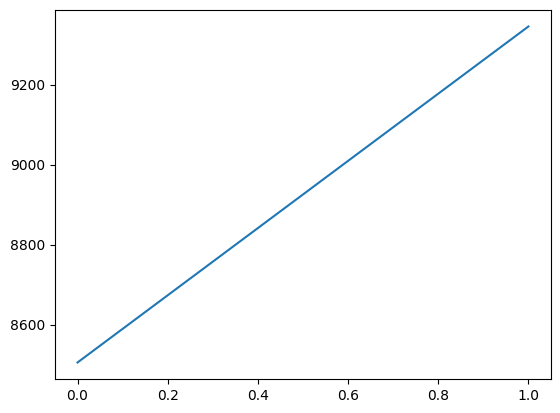

In [141]:
plt.plot(list(range(len(loss_hist))), loss_hist);

In [142]:
loss_hist

[8505.27977200045, 9345.485755165431]

In [176]:
features, target = next(iter(test_dataloader))
features

tensor([[ 0.0000,  0.0000,  1.0000,  0.3073,  0.0000,  1.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  1.0000,  0.6045,
         -0.9990,  0.0436,  0.6259, -0.7799]])

In [177]:
target

tensor([[7141.]])

In [178]:
model(features)

tensor([[4917.3179]], grad_fn=<AddmmBackward0>)

In [232]:
city_dists[city_indexes['Delhi']][city_indexes['Mumbai']]

1160

In [83]:
city_indexes['Delhi']

2

In [84]:
city_indexes['Mumbai']

5

In [180]:
import torch

In [181]:
torch.save(model, 'model1')

In [248]:
type(type(1.0))

type

In [ ]:
from flask import Flask, request, jsonify
from flask_cors import CORS
import torch
from torch import Tensor

model = torch.load('model')
model.eval()

city_indexes = {'Bangalore': 0, 'Chennai': 1, 'Delhi': 2, \
                'Hyderabad': 3, 'Kolkata': 4, 'Mumbai': 5}
city_dists = [
    [     0,          290,          1720,           1680,          1550,            830  ],
    [   290,            0,          1760,           1840,          1360,           1050  ],
    [  1720,         1760,             0,           1250,          1300,           1160  ],
    [  1680,         1840,          1250,              0,          2060,            850  ],
    [  1550,         1360,          1300,           2060,             0,           1650  ],
    [  830,          1050,          1160,            850,          1650,              0  ]
]

app = Flask(__name__)
CORS(app, resources={r"/getTicket": {"origins": "http://localhost:5173"}})

@app.route('/getTicket', methods=['POST'])
def get_ticket():
    data = request.get_json()

    if not data:
        return jsonify({'error': 'No input data provided'}), 400

    position = data.get('position')
    positionTo = data.get('positionTo')
    classPlane = data.get('classPlane')

    dist = city_dists[city_indexes[position]][city_indexes[positionTo]]
    cl = 0.0
    if classPlane == 'One':
        cl = 1.0

    input_data = Tensor([[cl, 1.0, 1.0, 180.0, 1.0, 0.0, 0.0, dist, -1.0, 0.0, -1.0, 0.0]])

    answer = model(input_data).item()

    # Логика обработки данных
    #print(f"Position: {position}, PositionTo: {positionTo}, ClassPlane: {classPlane}")
    print(f'Price:{answer}')

    return jsonify({
        'message': 'Data received successfully',
        'data': {
            'position': position,
            'positionTo': positionTo,
            'classPlane': classPlane,
            'price': str(answer)
        }
    }), 200

if __name__ == '__main__':
    app.run(debug=True)

In [271]:
input_data = Tensor([[1, 1.0, 1.0, 180.0, 1.0, 0.0, 0.0, 0.5, -1.0, 0.0, -1.0, 0.0]])
model2 = torch.load('model')
#answer = model(input_data).item()

In [272]:
answer = model2(input_data)
answer.item()

37530.31640625